# **Sésame, ouvre-toi:** *Preprocessing, ML et Shap*

### Installation des librairies nécéssaires

In [1]:
!pip install pycaret
!pip install lightgbm
!pip install lime
!pip install shap
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.6/483.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.9 MB/s eta 0:00:0

### Connexion au drive pour la données

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importation des librairies

In [3]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from pycaret.classification import ClassificationExperiment
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns

from datetime import datetime
from xgboost import XGBClassifier
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

import shap
import lime
from lime import lime_tabular
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.tree import DecisionTreeClassifier



### Récuperation de la données

In [4]:
violent_parsed = pd.read_csv('/content/drive/MyDrive/compas_data/cox-violent-parsed.csv')

### Visualisation et exploration de la data

In [5]:
violent_parsed

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,NaN,alexsandra beauchamps,alexsandra,beauchamps,29/12/2014,Female,21/12/1984,31,25 - 45,African-American,...,Risk of Violence,4,Low,29/12/2014,28/12/2014,07/01/2015,5,9,459,0
18312,NaN,winston gregory,winston,gregory,14/01/2014,Male,01/10/1958,57,Greater than 45,Other,...,Risk of Violence,1,Low,14/01/2014,13/01/2014,14/01/2014,0,0,808,0
18313,NaN,farrah jean,farrah,jean,09/03/2014,Female,17/11/1982,33,25 - 45,African-American,...,Risk of Violence,2,Low,09/03/2014,08/03/2014,09/03/2014,3,0,754,0
18314,NaN,florencia sanmartin,florencia,sanmartin,30/06/2014,Female,18/12/1992,23,Less than 25,Hispanic,...,Risk of Violence,4,Low,30/06/2014,15/03/2015,15/03/2015,2,0,258,0


In [6]:
# Visualisation des informations concernant la dataset
violent_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11001 non-null  float64
 1   name                     18316 non-null  object 
 2   first                    18316 non-null  object 
 3   last                     18316 non-null  object 
 4   compas_screening_date    18316 non-null  object 
 5   sex                      18316 non-null  object 
 6   dob                      18316 non-null  object 
 7   age                      18316 non-null  int64  
 8   age_cat                  18316 non-null  object 
 9   race                     18316 non-null  object 
 10  juv_fel_count            18316 non-null  int64  
 11  decile_score             18316 non-null  int64  
 12  juv_misd_count           18316 non-null  int64  
 13  juv_other_count          18316 non-null  int64  
 14  priors_count          

### Visualisation des valeurs manquantes

<Axes: >

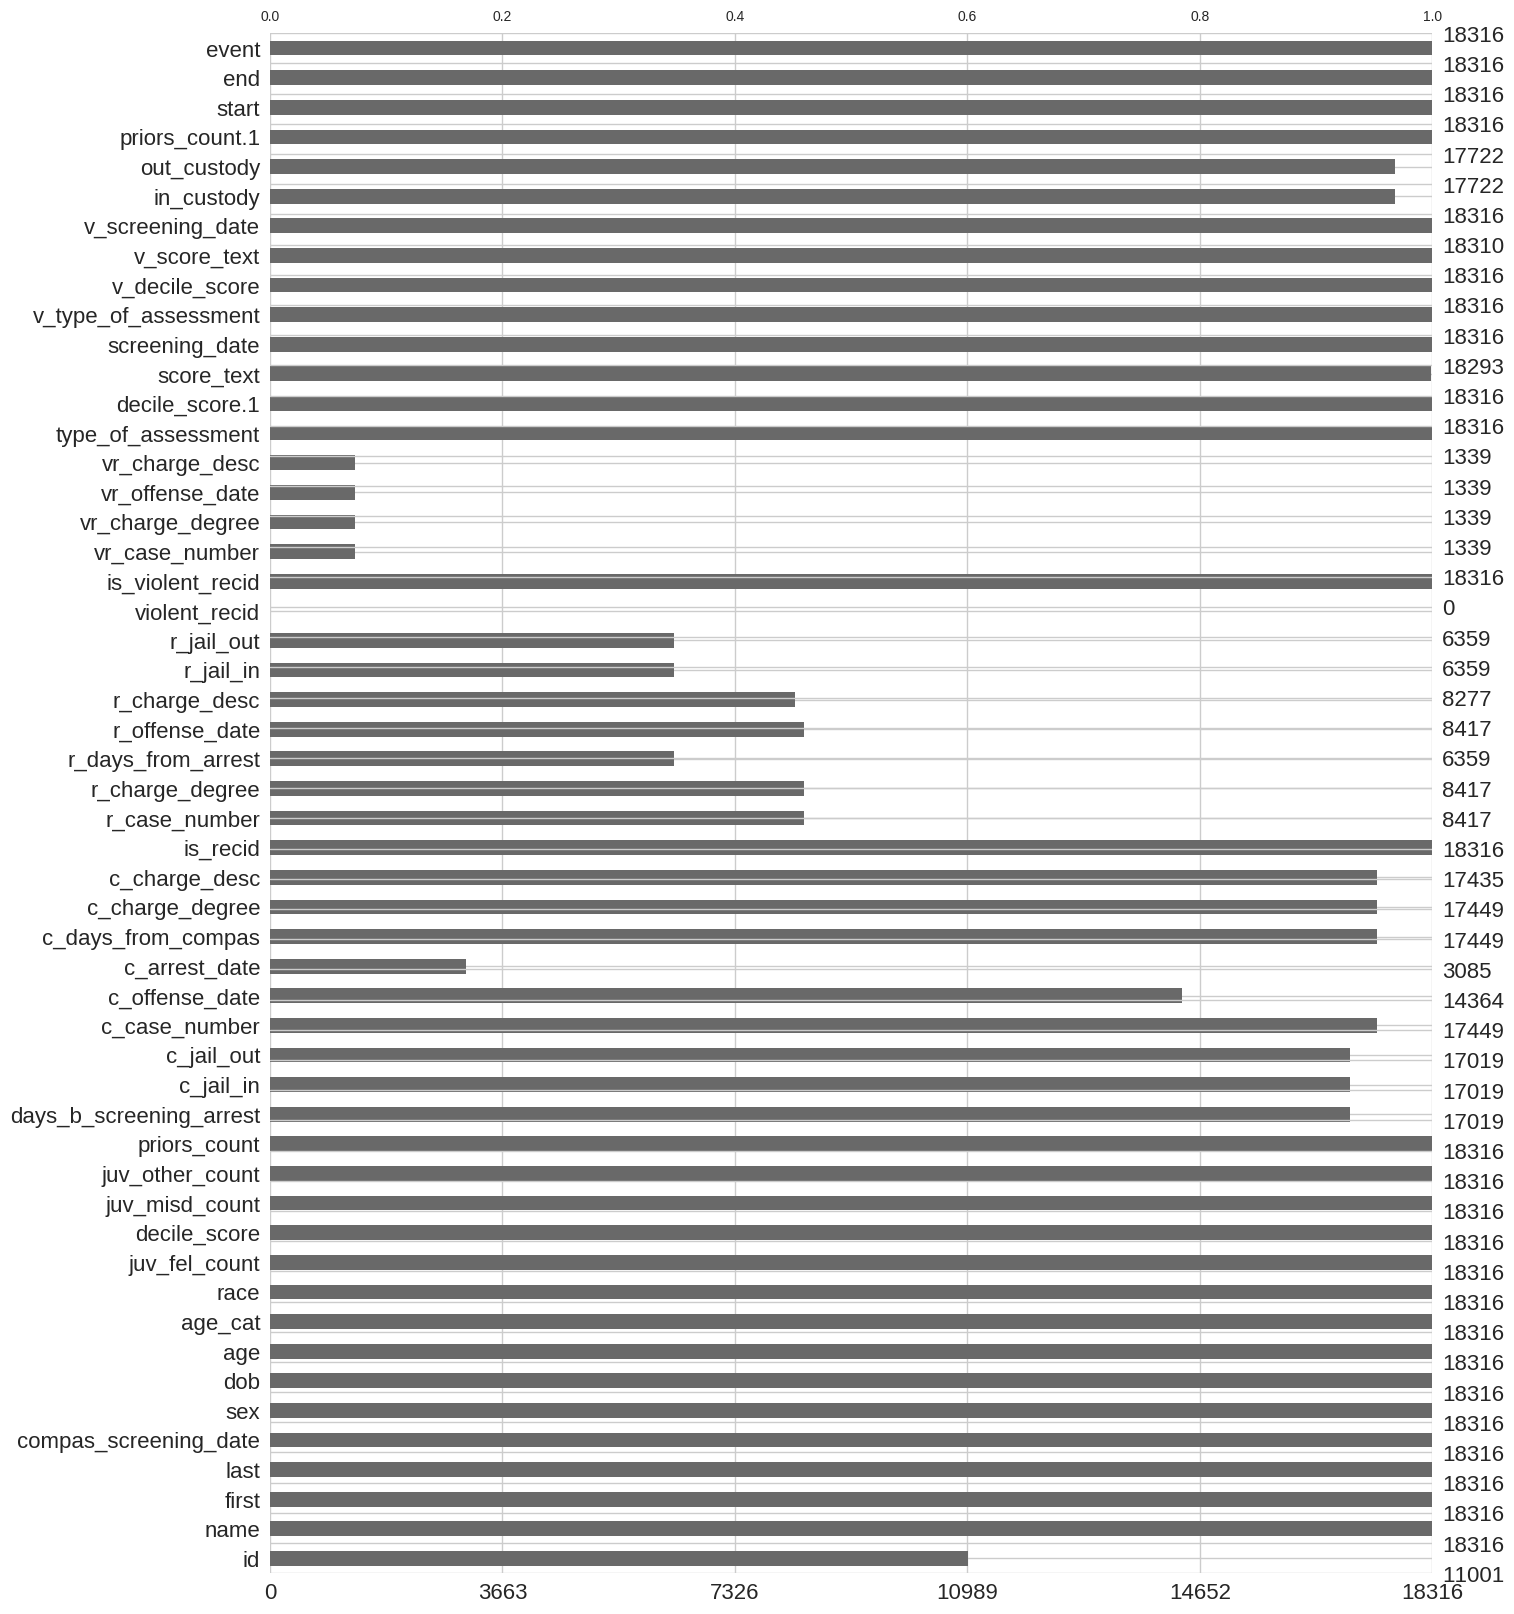

In [7]:
# Visualisation de valeurs manquantes avant
msno.bar(violent_parsed, figsize=(15, 20))

In [8]:
# Verification des pourcentage des valeurs manquantes
violent_parsed.isnull().mean()*100

id                          39.937759
name                         0.000000
first                        0.000000
last                         0.000000
compas_screening_date        0.000000
sex                          0.000000
dob                          0.000000
age                          0.000000
age_cat                      0.000000
race                         0.000000
juv_fel_count                0.000000
decile_score                 0.000000
juv_misd_count               0.000000
juv_other_count              0.000000
priors_count                 0.000000
days_b_screening_arrest      7.081240
c_jail_in                    7.081240
c_jail_out                   7.081240
c_case_number                4.733566
c_offense_date              21.576763
c_arrest_date               83.156803
c_days_from_compas           4.733566
c_charge_degree              4.733566
c_charge_desc                4.810002
is_recid                     0.000000
r_case_number               54.045643
r_charge_deg

In [9]:
# La suppression des Colonnes comportant des valeurs manquantes + de 50%

violent_parsed = violent_parsed.drop([
"c_offense_date","c_arrest_date",
"r_case_number","r_charge_degree",
"r_days_from_arrest","r_offense_date",
"r_charge_desc","r_jail_in",'priors_count.1',
"r_jail_out","violent_recid","vr_case_number",
"vr_charge_degree","vr_offense_date","vr_charge_desc",
"days_b_screening_arrest","c_case_number","c_charge_degree",
"c_charge_desc",
"c_days_from_compas",
"c_jail_in",
"c_jail_out","decile_score.1","end",
"event"            ,
"in_custody"               ,
"juv_fel_count"            ,
"juv_misd_count"          ,
"juv_other_count"          ,
"out_custody","start","v_screening_date"  ], axis=1)

<Axes: >

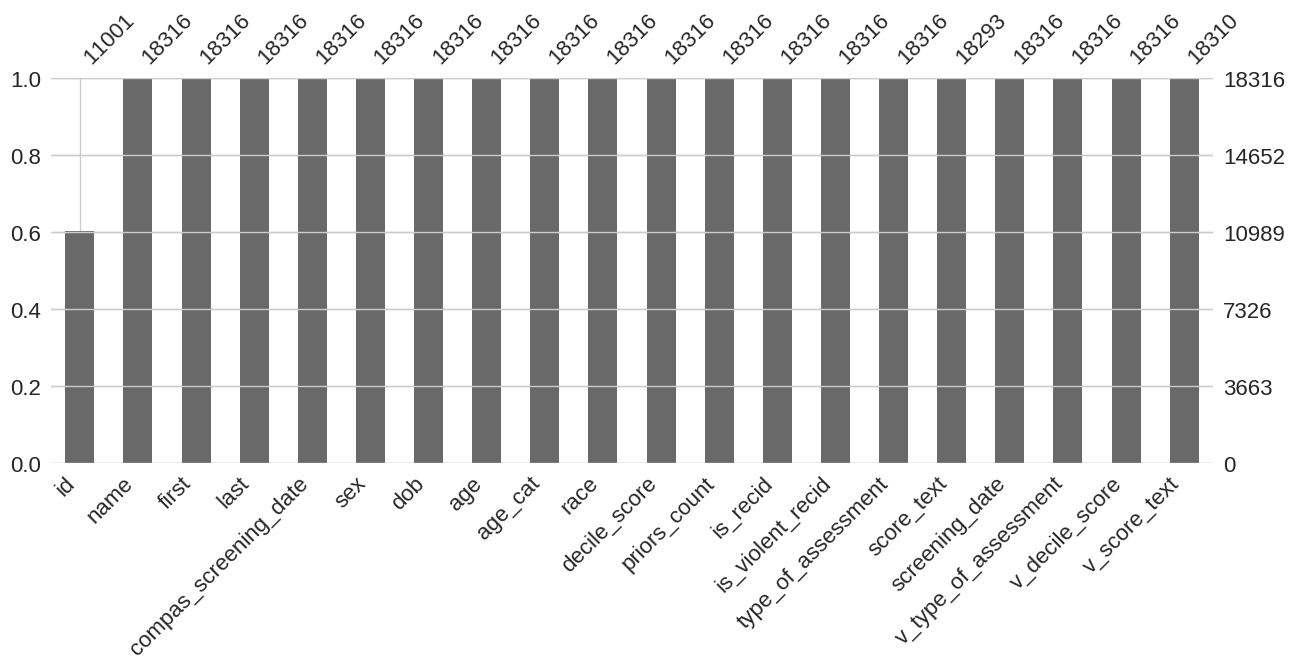

In [10]:
# Vérification des valeurs manquantes après 
msno.bar(violent_parsed, figsize=(15, 5))

In [11]:
# La selection des colonnes n'ayant pas beaucoup d'importance. Certaines colonnes ont été retiré car elles sont en doubles dans la dataset
data_violents = violent_parsed[violent_parsed.columns.difference(['id','name','dob','first','last','v_type_of_assessment','type_of_assessment','is_violent_recid','is_recid',"score_text","v_score_text",'decile_score','v_decile_score','compas_screening_date','screening_date'])]
data_violents

,age,age_cat,priors_count,race,sex
0,69,Greater than 45,0,Other,Male
1,69,Greater than 45,0,Other,Male
2,31,25 - 45,0,Caucasian,Male
3,34,25 - 45,0,African-American,Male
4,24,Less than 25,4,African-American,Male
...,...,...,...,...,...
18311,31,25 - 45,5,African-American,Female
18312,57,Greater than 45,0,Other,Male
18313,33,25 - 45,3,African-American,Female
18314,23,Less than 25,2,Hispanic,Female


In [12]:
# Visualisation des informations de ma dataset final
data_violents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           18316 non-null  int64 
 1   age_cat       18316 non-null  object
 2   priors_count  18316 non-null  int64 
 3   race          18316 non-null  object
 4   sex           18316 non-null  object
dtypes: int64(2), object(3)
memory usage: 715.6+ KB


In [13]:
# La deuxieme verification des valeurs manquantes
data_violents.isnull().mean()*100

age             0.0
age_cat         0.0
priors_count    0.0
race            0.0
sex             0.0
dtype: float64

In [14]:
# Sélection de la colonne target
label_1 = violent_parsed['is_violent_recid']

In [15]:
# Je cree une dataset copy, afin de travailler dessus sans touché a l'originale
data_violents_2 = data_violents.copy()

In [16]:
label_1.value_counts(normalize=True) * 100

0    92.689452
1     7.310548
Name: is_violent_recid, dtype: float64

Après avoir remarqué l'écart dans le nombre de classes, j'ai décidé d'effectuer un certain équilibrage des données. Pour cela, j'ai dû encoder les variables catégorielles (***sexe, ethnie, age_cat*** ) avec la librairie LabelEncoder afin de faciliter les processus  d'équilibrage

In [17]:
Sex_data_2 = preprocessing.LabelEncoder()
race_data_2= preprocessing.LabelEncoder()
age_cat_data= preprocessing.LabelEncoder()

In [18]:
data_violents_2['sex']=Sex_data_2.fit_transform(data_violents_2['sex'])
data_violents_2['age_cat']=age_cat_data.fit_transform(data_violents_2['age_cat'])
data_violents_2['race']=race_data_2.fit_transform(data_violents_2['race'])

In [19]:
# L'équilibrage des données est réalisé avec la librairie Smote en suréchantillonnage
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(data_violents_2, label_1)

In [20]:
# Après l'équilibrage réalisé, une phase de décodage a été fait afin de faciliter l'encodage final
X_resampled["sex"]= Sex_data_2.inverse_transform(X_resampled['sex'])
X_resampled["race"]=race_data_2.inverse_transform(X_resampled['race'])

In [21]:
X_resampled

,age,age_cat,priors_count,race,sex
0,69,1,0,Other,Male
1,69,1,0,Other,Male
2,31,0,0,Caucasian,Male
3,34,0,0,African-American,Male
4,24,2,4,African-American,Male
...,...,...,...,...,...
33949,26,0,10,African-American,Male
33950,22,2,1,African-American,Male
33951,27,0,9,African-American,Male
33952,28,0,0,Caucasian,Male


In [22]:
# Le fractionnement des données a été realisé afin de diviser les données en groupe  d'entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42)


In [23]:
X_train

,age,age_cat,priors_count,race,sex
16414,27,0,0,Caucasian,Male
1086,58,1,21,African-American,Male
25124,50,1,0,Caucasian,Female
18703,36,0,11,Asian,Male
18483,57,1,0,Caucasian,Male
...,...,...,...,...,...
16850,28,0,1,Hispanic,Male
6265,30,0,0,African-American,Male
11284,20,2,0,African-American,Female
860,30,0,1,Other,Male


In [24]:
df_encoded_race= pd.get_dummies(X_train["race"])
df_encoded_sex= pd.get_dummies(X_train[['sex']])

df_encoded_race_test= pd.get_dummies(X_test["race"])
df_encoded_sex_test= pd.get_dummies(X_test[['sex']])

In [25]:
df_encoded_race_test

,African-American,Asian,Caucasian,Hispanic,Native American,Other
27883,0,0,1,0,0,0
7251,1,0,0,0,0,0
33385,1,0,0,0,0,0
7969,0,0,0,0,0,1
6904,1,0,0,0,0,0
...,...,...,...,...,...,...
17635,0,0,0,1,0,0
30949,1,0,0,0,0,0
29795,1,0,0,0,0,0
5805,1,0,0,0,0,0


In [26]:
X_train_final = pd.concat([X_train[['age',"age_cat"	,"priors_count"]], df_encoded_race,df_encoded_sex], axis=1)
X_test_final = pd.concat([X_test[['age',"age_cat"	,"priors_count"]], df_encoded_race_test,df_encoded_sex_test], axis=1)

In [27]:
X_train_final

,age,age_cat,priors_count,African-American,Asian,Caucasian,Hispanic,Native American,Other,sex_Female,sex_Male
16414,27,0,0,0,0,1,0,0,0,0,1
1086,58,1,21,1,0,0,0,0,0,0,1
25124,50,1,0,0,0,1,0,0,0,1,0
18703,36,0,11,0,1,0,0,0,0,0,1
18483,57,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
16850,28,0,1,0,0,0,1,0,0,0,1
6265,30,0,0,1,0,0,0,0,0,0,1
11284,20,2,0,1,0,0,0,0,0,1,0
860,30,0,1,0,0,0,0,0,1,0,1


## Création de models de Machine Learning

### **Séléction de modèle**

In [28]:
# Utilisation d'autoMl pour selectionner le meilleur models
auto_ml_data_2 = ClassificationExperiment()
auto_ml_data_2.setup(X_train_final, target = y_train, session_id =1)

,Description,Value
0,Session id,1
1,Target,is_violent_recid
2,Target type,Binary
3,Original data shape,"(25465, 12)"
4,Transformed data shape,"(25465, 12)"
5,Transformed train set shape,"(17825, 12)"
6,Transformed test set shape,"(7640, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [29]:
# Meilleurs modèle
best = auto_ml_data_2.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7845,0.8709,0.8299,0.7601,0.7934,0.5690,0.5715,1.2310
rf,Random Forest Classifier,0.7832,0.8723,0.8422,0.7528,0.7949,0.5666,0.5707,1.8270
dt,Decision Tree Classifier,0.7818,0.8633,0.8299,0.7564,0.7914,0.5638,0.5665,0.4160
knn,K Neighbors Classifier,0.7544,0.8265,0.7990,0.7330,0.7642,0.5090,0.5116,0.3790
xgboost,Extreme Gradient Boosting,0.7506,0.8385,0.7673,0.7418,0.7542,0.5013,0.5018,1.4460
lightgbm,Light Gradient Boosting Machine,0.7212,0.8100,0.7043,0.7280,0.7159,0.4423,0.4427,0.5290
gbc,Gradient Boosting Classifier,0.6560,0.7139,0.6531,0.6559,0.6545,0.3121,0.3121,1.0390
ada,Ada Boost Classifier,0.6372,0.6818,0.6686,0.6283,0.6477,0.2745,0.2752,0.8670
ridge,Ridge Classifier,0.6096,0.0000,0.6731,0.5963,0.6323,0.2194,0.2214,0.1640
lda,Linear Discriminant Analysis,0.6096,0.6509,0.6731,0.5963,0.6323,0.2194,0.2214,0.2590


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

## Création et entrainement du modéle

In [30]:
ExTreesClass = ExtraTreesClassifier(n_estimators=100, random_state=0)
ExTreesClass.fit(X_train_final, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=0, verbose=0, warm_start=False)

## Prédiction

In [31]:
ExTreesClass_pred = ExTreesClass.predict(X_test_final)

## **Evaluation du model**

In [32]:
print(classification_report(y_test, ExTreesClass_pred))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      4212
           1       0.77      0.84      0.80      4277

    accuracy                           0.79      8489
   macro avg       0.79      0.79      0.79      8489
weighted avg       0.79      0.79      0.79      8489



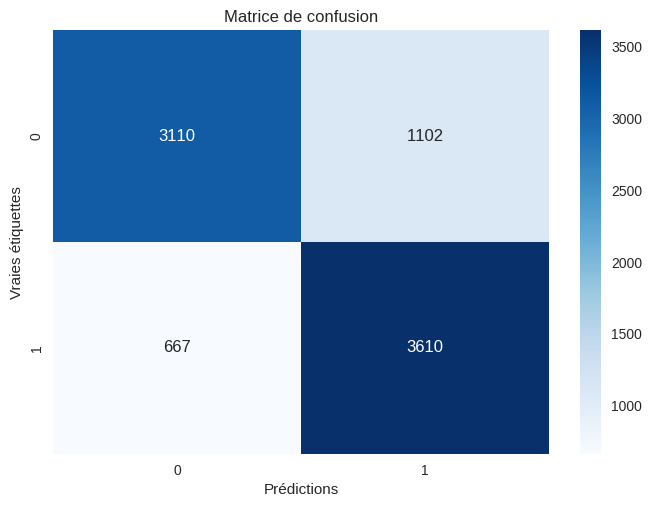

In [33]:
cm = confusion_matrix(y_test, ExTreesClass_pred)

# Créer une heatmap avec Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Ajouter des étiquettes et des titres
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de confusion")

# Afficher la matrice de confusion
plt.show()

# **Shap (Interprétation, identification et Vérification )**

## Interprétation du modèle et identification des contributions de differentes features




100%|===================| 16975/16978 [11:31<00:00]       

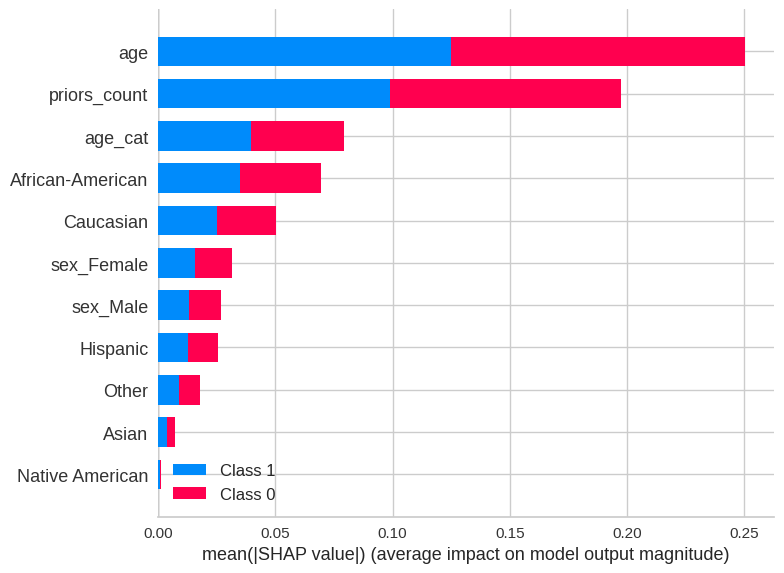

In [34]:
explainer_data_Extre = shap.Explainer(ExTreesClass, X_train_final)
shap_values_data_2 = explainer_data_Extre.shap_values(X_test_final)

feature_contributions = shap.summary_plot(shap_values_data_2, X_test_final, plot_type="bar")

In [35]:
def shap_force_plot(explainer, values, X):
    """
    shap_value can be an element of explainer.shap_values(train_X) or subset
    """
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[0], values[0], X))
    return

In [36]:
tree_explainer = shap.TreeExplainer(ExTreesClass)
tree_values = tree_explainer.shap_values(X_train_final)

## Interprétation de forces

In [37]:
index = 1
print("Real value is :",y_train[index])
print("Predicted value is :", ExTreesClass_pred[index])
print( X_train_final.iloc[index, :])
tree_values_array = np.array(tree_values)

print("Predicted value is:", ExTreesClass_pred[index])
shap_force_plot(tree_explainer, tree_values_array[index, :], X_train_final.iloc[index, :])




Real value is : 0
Predicted value is : 0
age                 58
age_cat              1
priors_count        21
African-American     1
Asian                0
Caucasian            0
Hispanic             0
Native American      0
Other                0
sex_Female           0
sex_Male             1
Name: 1086, dtype: int64
Predicted value is: 0


# **Amélioration du model**

## L'Échantillonnages

In [38]:
# Spécifier le nombre d'échantillons souhaité pour chaque valeur de la caractéristique
n_samples = 100

# Target  pour l'échantillonnage
specific_feature = 'race'

# Liste des valeurs uniques de la caractéristique
unique_values = X_resampled[specific_feature].unique()

# Effectuer l'échantillonnage pour chaque valeur de la caractéristique
sampled_data = pd.DataFrame()

for value in unique_values:
    subset = X_resampled[X_resampled[specific_feature] == value].sample(n=n_samples, random_state=42)
    sampled_data = pd.concat([sampled_data, subset])

# Afficher les échantillons

In [39]:
sampled_data['race'].value_counts()

Other               100
Caucasian           100
African-American    100
Hispanic            100
Asian               100
Native American     100
Name: race, dtype: int64

In [40]:
sampled_data

,age,age_cat,priors_count,race,sex
31965,39,0,1,Other,Male
16193,42,0,1,Other,Male
31130,21,2,0,Other,Male
16366,54,1,2,Other,Male
13927,25,0,1,Other,Male
...,...,...,...,...,...
33474,36,0,3,Native American,Male
30519,32,0,6,Native American,Male
14983,20,2,1,Native American,Male
22656,39,0,8,Native American,Male


In [41]:
# Récuperation des target semblables
index_sampled_data = sampled_data.index
y_label_sampled = y_resampled.loc[index_sampled_data]

print(y_label_sampled)

31965    1
16193    0
31130    1
16366    1
13927    0
        ..
33474    1
30519    1
14983    1
22656    1
29789    1
Name: is_violent_recid, Length: 600, dtype: int64


In [42]:
# Fractionnement de la dataset
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(sampled_data, y_label_sampled, random_state=42)


### L'encodage des nouvelles datas

In [43]:
df_encoded_race_sample= pd.get_dummies(X_train_sample["race"])
df_encoded_sex_sample= pd.get_dummies(X_train_sample[['sex']])

df_encoded_race_test_sample= pd.get_dummies(X_test_sample["race"])
df_encoded_sex_test_sample= pd.get_dummies(X_test_sample[['sex']])

In [44]:
X_train_Sample_final = pd.concat([X_train_sample[['age',"age_cat"	,"priors_count"]], df_encoded_race_sample,df_encoded_sex_sample], axis=1)
X_test_Sample_final = pd.concat([X_test_sample[['age',"age_cat"	,"priors_count"]], df_encoded_race_test_sample,df_encoded_sex_test_sample], axis=1)

In [45]:
X_test_Sample_final

,age,age_cat,priors_count,African-American,Asian,Caucasian,Hispanic,Native American,Other,sex_Female,sex_Male
8912,56,1,0,0,0,1,0,0,0,0,1
29573,26,0,2,0,1,0,0,0,0,0,1
2234,38,0,25,0,0,0,0,1,0,0,1
9798,31,0,0,0,0,0,0,0,1,0,1
1444,41,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
28518,40,0,3,0,0,1,0,0,0,1,0
17151,22,2,0,0,0,0,1,0,0,0,1
20160,48,1,23,0,1,0,0,0,0,0,1
2133,39,0,0,0,0,0,0,0,1,0,1


### Grid search pour trouver les meilleurs hyperparamètres 

In [46]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Créer l'estimateur ExtraTreesClassifier
estimator = ExtraTreesClassifier()

# Créer un objet GridSearchCV pour effectuer la recherche de grille
grid_search = GridSearchCV(estimator, param_grid=param_grid, cv=5)

# Exécuter la recherche de grille sur les données
grid_search.fit(X_train_Sample_final, y_train_sample)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)
print("Meilleur score de validation croisée :")
print(grid_search.best_score_)

Meilleurs paramètres trouvés :
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Meilleur score de validation croisée :
0.7244444444444444


### Entrainement du nouveau modèle

In [47]:
best_params = grid_search.best_params_

# Créer un nouveau modèle avec les meilleurs paramètres
Last_model = ExtraTreesClassifier(**best_params)

# Entraîner le modèle avec les données
Last_model.fit(X_train_Sample_final, y_train_sample)

pred_decision_tree= Last_model.predict(X_test_Sample_final)
accuracy = accuracy_score(y_test_sample, pred_decision_tree)
print("Exactitude : {:.2f}%".format(accuracy * 100))

Exactitude : 76.00%


# Shap

In [49]:
explainer_data_decision = shap.Explainer(Last_model, X_train_Sample_final)
shap_values_data_decision = explainer_data_decision.shap_values(X_test_Sample_final)

 96%|=================== | 287/300 [00:21<00:00]       

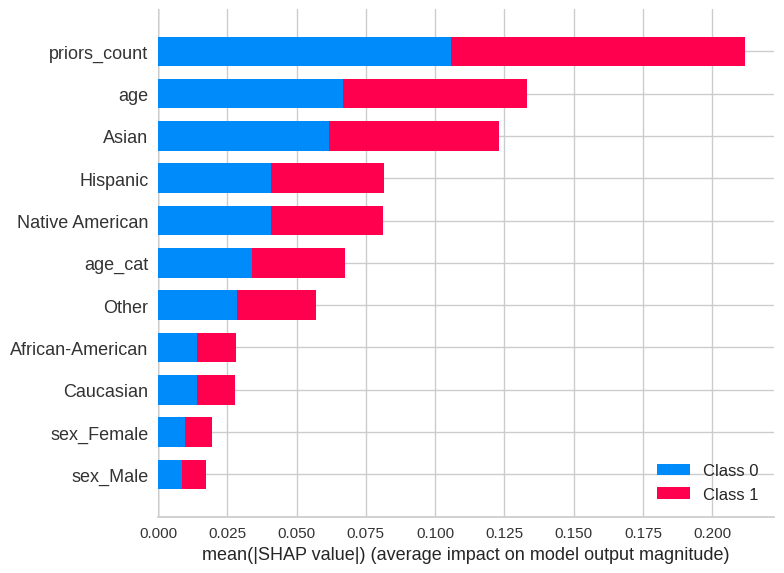

In [50]:
feature_contributions = shap.summary_plot(shap_values_data_decision, X_test_Sample_final, plot_type="bar")